In [1]:
from PosSelect_Functions_Old import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import wilcoxon
from scipy.optimize import curve_fit
from scipy.stats import fisher_exact

hfont = {'fontname':'Arial'}
plt.rcParams["font.family"] = "Arial"

#Code borrowed heavily from here: https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
plt.rcParams.update(
    {"text.usetex": False}
)

#Define a logarithmic function to fit to the data
def plot_stuff(df, title, xlabel, ylabel):
    def func(x, a, c, d):
        return a + d*np.log(x + c)

    #Fit said function
    popt, pcov = curve_fit(func, xdata=df["AF bin"], ydata=df["Alpha"], maxfev = 100000)
    sns.scatterplot(x=df["AF bin"], y=df["Alpha"])
    xx = np.linspace(0.1, 1, 100)
    yy = func(xx, *popt)
    plt.title(title, size = 18)
    plt.xlabel(xlabel, size = 15)
    plt.ylabel(ylabel, size = 15)
    plt.plot(xx, yy)


C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
#Read in data and filter
v = pd.read_csv("Fixed_Mmd.Ready.mm39.bed", sep = "\t", header = None)
v["Position"] = v[0] + ":" + v[2].astype(str)
v.columns = [0, 1, 2, "Domesticus", "Musculus", "Castaneus", "Spretus", "Caroli", "Pahari", "Derived", "PhyloP447", "NearestGene", "NearestDist", "SpecSup447", "Position"]
v = v.drop_duplicates("Position")
v = v[["Position", "Domesticus", "Musculus", "Castaneus", "Spretus", "Caroli", "Pahari", "Derived", "PhyloP447", "NearestGene", "NearestDist", "SpecSup447"]].copy()

v = v[v["PhyloP447"] != "."]
v = v[v["SpecSup447"] != "."]
v = v[v["NearestGene"] != "."]

v["PhyloP447"] = v["PhyloP447"].astype(float)
v["SpecSup447"] = v["SpecSup447"].astype(float)

vv = pd.read_csv("Poly_Mmd.Ready.mm39.bed", sep = "\t", header = None)

vv["Position"] = vv[0] + ":" + vv[2].astype(str)
vv.columns = [0, 1, 2, "MajorAllele", "MinorAllele", "MAFMaxAcrossAncestry", "DerivedAllele", "UnfoldedMAF", "MusculusReference", "Spretus", "Caroli", "Pahari", "DerivedFromSubspecies", "PhyloP447", "NearestGene", "NearestDist", "SpecSup447", "Position"]
vv = vv.drop_duplicates("Position")
vv = vv[["Position", "MajorAllele", "MinorAllele", "MAFMaxAcrossAncestry", "DerivedAllele", "UnfoldedMAF", "MusculusReference", "Spretus", "Caroli", "Pahari", "DerivedFromSubspecies", "PhyloP447", "NearestGene", "NearestDist", "SpecSup447"]].copy()

vv = vv[vv["PhyloP447"] != "."]
vv = vv[vv["SpecSup447"] != "."]
vv = vv[vv["NearestGene"] != "."]

vv["PhyloP447"] = vv["PhyloP447"].astype(float)
vv["SpecSup447"] = vv["SpecSup447"].astype(float)

#Only want musculus derived
v = v[v["Derived"].isin(["MusDer"])]
vv = vv[~vv["DerivedAllele"].isin(["Amb"])]

v.index = v["Position"]
vv.index = vv["Position"]

v = v[~v["Position"].isin(vv["Position"])]

vv = vv[(vv["UnfoldedMAF"] < 0.9) & (vv["UnfoldedMAF"] > 0.1)]

C:\Users\astar\AppData\Local\Temp\ipykernel_19816\1958018314.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  v = pd.read_csv("Fixed_Mmd.Ready.mm39.bed", sep = "\t", header = None)
C:\Users\astar\AppData\Local\Temp\ipykernel_19816\1958018314.py:14: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  vv = pd.read_csv("Poly_Mmd.Ready.mm39.bed", sep = "\t", header = None)


In [5]:
#Read in VEP information
v_vep = pd.read_csv("Fixed_Mmd_AllVEPs.txt", sep = "\t").set_index("Position")
vv_vep = pd.read_csv("Poly_Mmd_AllVEPs.txt", sep = "\t").set_index("Position")

fixed_syn = list(v_vep[v_vep["Effect"].isin(["Syn"])].index)
poly_syn = list(vv_vep[vv_vep["Effect"].isin(["Syn"])].index)



In [ ]:
fixed_mis = list(v_vep[v_vep["Effect"].isin(["Mis"])].index)
poly_mis = list(vv_vep[vv_vep["Effect"].isin(["Mis"])].index)


In [ ]:
#Ortholog information
orthos = pd.read_csv("Alecto_Musculus_Homo_Orthos.txt", sep = ',')
orthos = orthos.dropna()
orthos = orthos[(orthos["Mouse homology type"] == "ortholog_one2one") & (orthos["Megabat homology type"] == "ortholog_one2one")]
orthos = orthos.drop_duplicates("Gene stable ID")

orth2 = pd.read_csv("Orthologs_HumMouseMarm.txt", sep = "\t")
orth2 = orth2[["Gene stable ID", "Gene name"]]
orthos = orthos.set_index("Gene stable ID").join(orth2.set_index("Gene stable ID"))

v_use = v[v["NearestGene"].isin(orthos["Mouse gene name"])]
vv_use = vv[vv["NearestGene"].isin(orthos["Mouse gene name"])]


In [6]:
v_vep = pd.read_csv("Fixed_Mmd_AllVEPs.txt", sep = "\t").set_index("Position")
vv_vep = pd.read_csv("Poly_Mmd_AllVEPs.txt", sep = "\t").set_index("Position")

fixed_mis = list(v_vep[v_vep["Effect"].isin(["Mis"])].index)
poly_mis = list(vv_vep[vv_vep["Effect"].isin(["Mis"])].index)

fixed_syn = list(v_vep[v_vep["Effect"].isin(["Syn"])].index)
poly_syn = list(vv_vep[vv_vep["Effect"].isin(["Syn"])].index)

fixed_3p = list(v_vep[v_vep["Effect"].isin(["3P"])].index)
poly_3p = list(vv_vep[vv_vep["Effect"].isin(["3P"])].index)

fixed_5p = list(v_vep[v_vep["Effect"].isin(["5P"])].index)
poly_5p = list(vv_vep[vv_vep["Effect"].isin(["5P"])].index)

fixed_nc = list(v_vep[v_vep["Effect"].isin(["NC"])].index)
poly_nc = list(vv_vep[vv_vep["Effect"].isin(["NC"])].index)

v_vep = 0
vv_vep = 0

#Chosen based on being number of rodents + 8
vv = vv[vv["SpecSup447"] > 61]
v = v[v["SpecSup447"] > 61]

In [7]:
#Remove equivalent of HLA
toss = []
for i in np.unique(vv["NearestGene"]):
    if "H2-" in i:
        toss.append(i)
        
for i in np.unique(v["NearestGene"]):
    if "H2-" in i:
        toss.append(i)

v = v[~v["NearestGene"].isin(toss)]
vv = vv[~vv["NearestGene"].isin(toss)]

In [8]:
#For fair comparison with bat, only use 1-1 orthos and toss all nonsyn/syn sites
orthos = pd.read_csv("Alecto_Musculus_Homo_Orthos.txt", sep = ',')
orthos = orthos.dropna()
orthos = orthos[(orthos["Mouse homology type"] == "ortholog_one2one") & (orthos["Megabat homology type"] == "ortholog_one2one")]
orthos = orthos.drop_duplicates("Gene stable ID")

orth2 = pd.read_csv("Orthologs_HumMouseMarm.txt", sep = "\t")
orth2 = orth2[["Gene stable ID", "Gene name"]]
orthos = orthos.set_index("Gene stable ID").join(orth2.set_index("Gene stable ID"))

v_use = v[v["NearestGene"].isin(orthos["Mouse gene name"])]
vv_use = vv[vv["NearestGene"].isin(orthos["Mouse gene name"])]

v_use = v_use[v_use["Position"].isin(fixed_nc + fixed_3p + fixed_5p)]
vv_use = vv_use[vv_use["Position"].isin(poly_nc + poly_3p + poly_5p)]

v_use = v[~v["Position"].isin(fixed_syn)]
vv_use = vv[~vv["Position"].isin(poly_syn)]

C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.09394449381677168


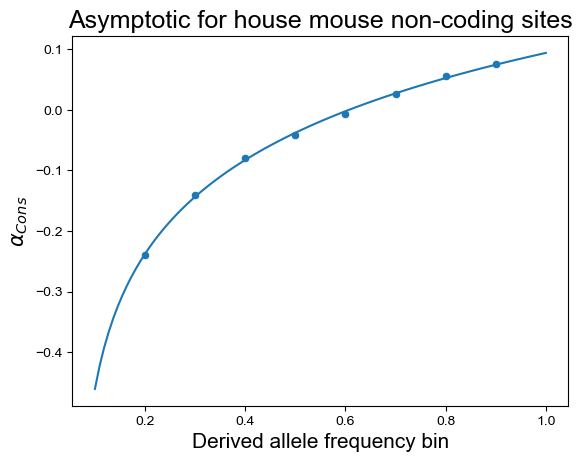

In [16]:
#Asymptotic
alpha, to_plot = asymptotic_unfold_cutoff(v_use, vv_use, start = 0.1, dn_cut = 0.0001, to_plot_curve = False, cuttt = 0.95)
plot_stuff(to_plot, title = "Asymptotic for house mouse non-coding sites", ylabel = "$\\alpha_{Cons}$", xlabel = "Derived allele frequency bin")
print(alpha)

In [10]:
vv_use2 = vv_use[(vv_use["UnfoldedMAF"] > 0.5) & (vv_use["UnfoldedMAF"] < 0.9)]
vv_use2

,Position,MajorAllele,MinorAllele,MAFMaxAcrossAncestry,DerivedAllele,UnfoldedMAF,MusculusReference,Spretus,Caroli,Pahari,DerivedFromSubspecies,PhyloP447,NearestGene,NearestDist,SpecSup447
Position,,,,,,,,,,,,,,,
chr1:3077980,chr1:3077980,A,G,0.444,A,0.556,G,G,G,A,TP,-1.950,Xkr4,662946,396.0
chr1:3117545,chr1:3117545,A,T,0.167,A,0.833,T,A,T,C,Amb,0.244,Xkr4,623381,282.0
chr1:3165884,chr1:3165884,A,G,0.167,A,0.833,G,A,G,G,TP,-0.233,Xkr4,575042,425.0
chr1:3168212,chr1:3168212,G,C,0.167,G,0.833,C,G,C,C,TP,0.337,Xkr4,572714,370.0
chr1:3185113,chr1:3185113,A,G,0.463,A,0.537,G,G,G,G,TP,0.754,Xkr4,555813,416.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:168704990,chrX:168704990,G,T,0.481,G,0.519,T,G,T,T,T,-0.548,Mid1,41368,230.0
chrX:168708152,chrX:168708152,G,A,0.444,G,0.556,A,G,A,A,A,-3.977,Mid1,44530,417.0
chrX:168708176,chrX:168708176,G,A,0.333,G,0.667,A,G,A,A,A,0.697,Mid1,44554,417.0


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

(0.04014958795813384, 2.177, [[176053, 3212489], [72894, 1385507]], [[176255, 3212287], [72953, 1385448]], <Figure size 1000x600 with 1 Axes>) 1.0722832580650374e-19


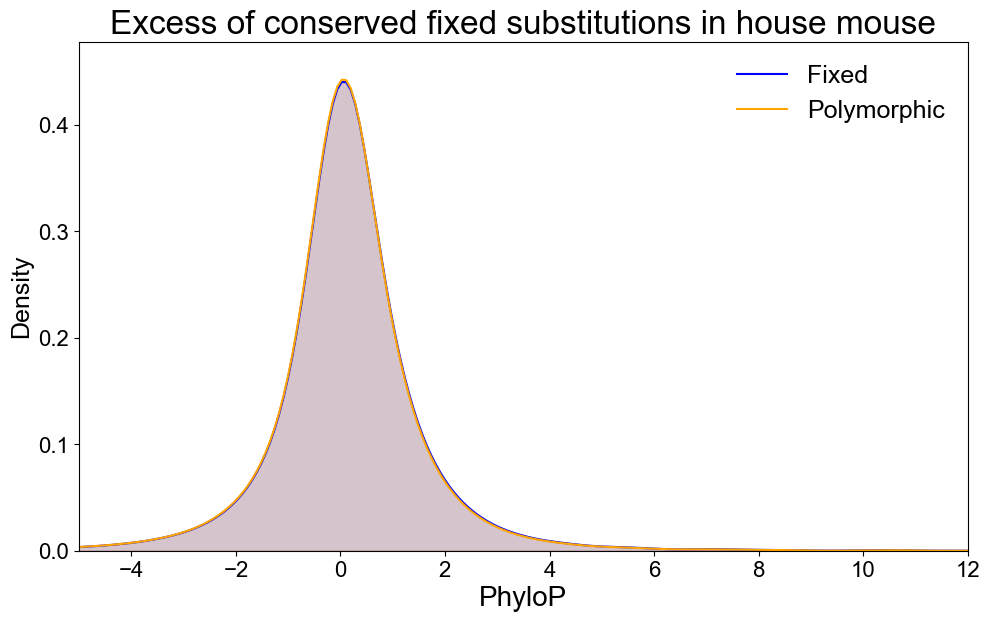

In [11]:
vvv = prepare_alpha(v_use, vv_use2)
x2 = [np.float64(x) for x in list(v_use["PhyloP447"])]
yvals2 = [np.float64(j) for j in list(vv_use2["PhyloP447"])]
yvals2.sort()
cuttt = 0.95
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]

alpha = compute_alpha_cutoff(vvv, dn_cut = 0.01, plot = True, cutoff = cutoff, title = "Excess of conserved fixed substitutions in house mouse")
table1 = alpha[2]
table2 = alpha[3]
p = (fisher_exact(table1)[1] + fisher_exact(table2)[1])/2
print(alpha, p)

C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

(0.04014958795813384, 2.177, [[176053, 3212489], [72894, 1385507]], [[176255, 3212287], [72953, 1385448]], <Figure size 1000x600 with 1 Axes>) 1.0722832580650374e-19


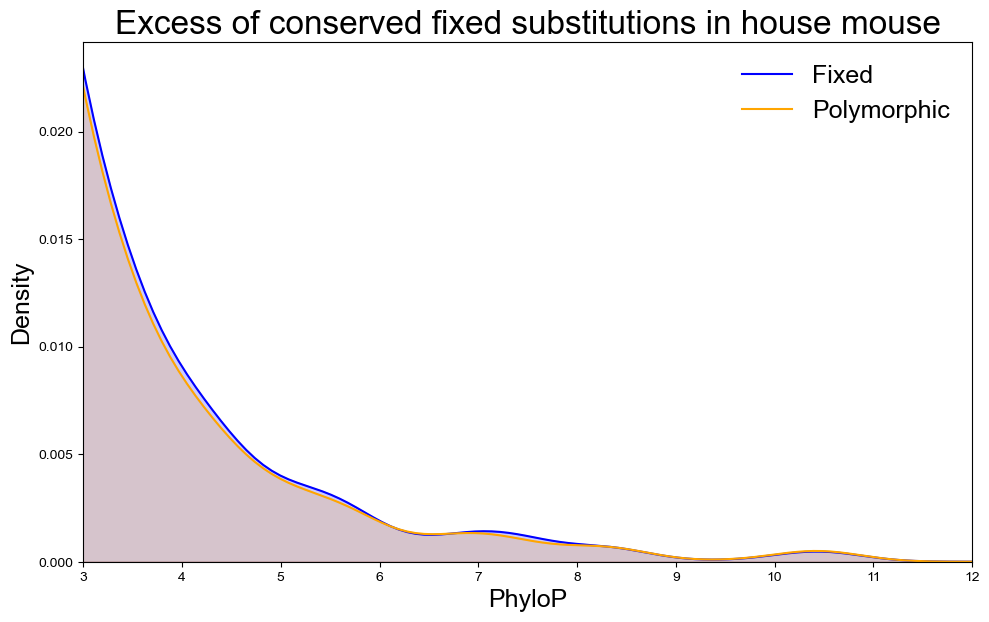

In [20]:
vvv = prepare_alpha(v_use, vv_use2)
x2 = [np.float64(x) for x in list(v_use["PhyloP447"])]
yvals2 = [np.float64(j) for j in list(vv_use2["PhyloP447"])]
yvals2.sort()
cuttt = 0.95
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]

alpha = compute_alpha_cutoff(vvv, dn_cut = 0.01, plot = True, cutoff = cutoff, title = "Excess of conserved fixed substitutions in house mouse", window = [3, 12])
table1 = alpha[2]
table2 = alpha[3]
p = (fisher_exact(table1)[1] + fisher_exact(table2)[1])/2
print(alpha, p)

C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.09394449381677168


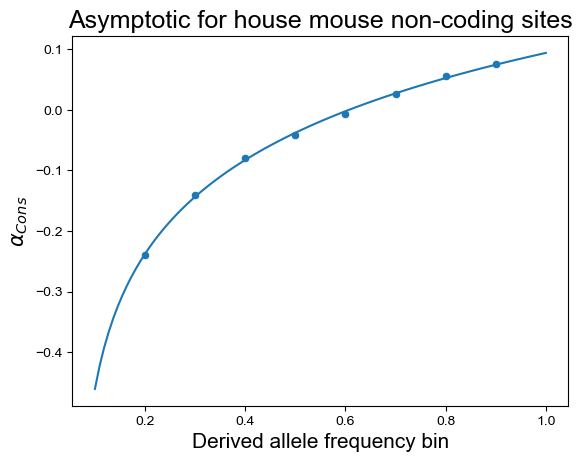

In [14]:
alpha, to_plot = asymptotic_unfold_cutoff(v_use, vv_use, start = 0.1, dn_cut = 0.0001, to_plot_curve = False, cuttt = 0.95)
plot_stuff(to_plot, title = "Asymptotic for house mouse non-coding sites", ylabel = "$\\alpha_{Cons}$", xlabel = "Derived allele frequency bin")
print(alpha)

In [36]:
#Splitting to deal with VEP errors
out = []
c = 0
for index, row in to_do_vep.iterrows():
    c += 1
    if row["MusculusReference"] == row["MajorAllele"]:
        out.append(list(row[["Chrom", "Pos", 1, "MusculusReference", "MinorAllele", 2, 3, 4]]))
    elif row["MusculusReference"] == row["MinorAllele"]:
        out.append(list(row[["Chrom", "Pos", 1, "MusculusReference", "MajorAllele", 2, 3, 4]]))

df = pd.DataFrame(out)
df.to_csv("Mus_VEP/Poly_Mmd_VEP12_chr4_L277013.vcf", sep = "\t", header = False, index = False)


In [83]:
v_vep_rest = v_vep[v_vep["Chrom"].isin(["X", "Y"])]
v_vep_rest_X = v_vep_rest[(~v_vep_rest["Pos"].astype(int).isin(bleh[1])) & (v_vep_rest["Chrom"].isin(["X"]))]
v_vep_rest_Y = v_vep[v_vep["Chrom"].isin(["Y"])]
v_vep_rest_X.to_csv("Mus_VEP/Fixed_Mmd_VEP14.vcf", header = False, index = False)

In [252]:

x = pd.read_csv("Mus_VEP/Poly_Mmd_VEP12_chr4.vcf", sep = "\t", header = None)
x = x.sort_values(1)
x.head(277013).to_csv("Mus_VEP/Poly_Mmd_VEP12_chr4_L277013.vcf", header = False, index = False, sep = "\t")
x

,0,1,2,3,4,5,6,7
0,4,3139093,.,A,G,.,.,.
1,4,3166969,.,G,C,.,.,.
2,4,3167846,.,T,A,.,.,.
3,4,3169016,.,C,A,.,.,.
4,4,3169487,.,A,C,.,.,.
...,...,...,...,...,...,...,...,...
554022,4,148957217,.,T,G,.,.,.
554023,4,148957576,.,C,T,.,.,.
554024,4,148958024,.,G,A,.,.,.
554025,4,148958533,.,G,A,.,.,.


In [261]:
x = pd.read_csv("Mus_VEP/Fixed_Mmd_VEP14.vcf", header = None)
x.to_csv("Mus_VEP/Fixed_Mmd_VEP14.vcf", index = False, header = False, sep = "\t")

In [165]:
x = pd.read_csv("Mus_VEP/Fixed_Mmd_VEP4_chr14.vcf", sep = "\t", header = None)
x = x.sort_values(1)
x.tail(272936-135000).to_csv("Mus_VEP/Fixed_Mmd_VEP4_chr14_L137936.vcf", header = False, index = False, sep = "\t")

In [219]:
x = pd.read_csv("Mus_VEP/Fixed_Mmd_VEP9_chr4.vcf", sep = "\t", header = None)
x = x.sort_values(1)
x.tail(228342).to_csv("Mus_VEP/Fixed_Mmd_VEP9_chr4_L228342.vcf", header = False, index = False, sep = "\t")
x


,0,1,2,3,4,5,6,7
0,4,3103995,.,G,A,.,.,.
1,4,3134336,.,T,C,.,.,.
2,4,3151963,.,T,C,.,.,.
3,4,3221731,.,A,G,.,.,.
4,4,3230921,.,T,C,.,.,.
...,...,...,...,...,...,...,...,...
456679,4,149933704,.,T,C,.,.,.
456680,4,149933966,.,C,T,.,.,.
456681,4,149934011,.,G,C,.,.,.
456682,4,149934728,.,C,T,.,.,.


In [15]:
#Process and consolidate the VEP outputs
import os
mis_all = []
three_all = []
five_all = []
syn_all = []
nc_all = []
for file in os.listdir("Mus_VEP"):
    if "Output" in file and "Fixed" in file:
        print(file)
        vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")
        mis = []
        three = []
        five = []
        syn = []
        nc = []
        for index, row in vep.iterrows():
            if "missense" in row["Consequence"] and "NMD" not in row["Consequence"]:
                mis.append(row["Location"].split("-")[0])
            elif "3_prime_UTR" in row["Consequence"] and "NMD" not in row["Consequence"]:
                three.append(row["Location"].split("-")[0])
            elif "5_prime_UTR" in row["Consequence"] and "NMD" not in row["Consequence"]:
                five.append(row["Location"].split("-")[0])
            elif "synonymous" in row["Consequence"] and "NMD" not in row["Consequence"]:
                syn.append(row["Location"].split("-")[0])
                nc.append(row["Location"].split("-")[0])
            else:
                nc.append(row["Location"].split("-")[0])
        mis = list(set(mis))
        three = list(np.setdiff1d(list(set(three)), mis))
        five = list(np.setdiff1d(np.setdiff1d(list(set(five)), mis), three))
        syn = list(np.setdiff1d(np.setdiff1d(np.setdiff1d(list(set(syn)), mis), three), five))
        nc = list(np.setdiff1d(np.setdiff1d(np.setdiff1d(list(set(nc)), mis), three), five))

        print(len(nc) + len(mis) + len(three) + len(five))
        
        mis_all = mis_all + mis
        three_all = three_all + three
        five_all = five_all + five
        syn_all = syn_all + syn
        nc_all = nc_all + nc
        
veps = pd.DataFrame(["chr" + x for x in mis_all + three_all + five_all + syn_all + nc_all])
veps["Effect"] = list(np.repeat("Mis", len(mis_all))) + list(np.repeat("3P", len(three_all))) + list(np.repeat("5P", len(five_all))) + list(np.repeat("Syn", len(syn_all))) + list(np.repeat("NC", len(nc_all)))
veps.columns = ["Position", "Effect"]
veps.to_csv("Fixed_Mmd_AllVEPs.txt", sep = "\t", index = False)

Fixed_Mmd_VEP10_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\1272783498.py:10: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


600000
Fixed_Mmd_VEP11_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\1272783498.py:10: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


600000
Fixed_Mmd_VEP12_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\1272783498.py:10: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


600000
Fixed_Mmd_VEP13_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\1272783498.py:10: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


600000
Fixed_Mmd_VEP14_Output.txt
168569
Fixed_Mmd_VEP1_Output.txt
600000
Fixed_Mmd_VEP2_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\1272783498.py:10: DtypeWarning: Columns (23,30) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


600000
Fixed_Mmd_VEP3_Output.txt
600000
Fixed_Mmd_VEP4_chr13_Output.txt
327064
Fixed_Mmd_VEP4_chr14_F135000_Output.txt
135000
Fixed_Mmd_VEP4_chr14_L137936_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\1272783498.py:10: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


137936
Fixed_Mmd_VEP5_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\1272783498.py:10: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


600000
Fixed_Mmd_VEP6_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\1272783498.py:10: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


600000
Fixed_Mmd_VEP7_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\1272783498.py:10: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


600000
Fixed_Mmd_VEP8_Output.txt
600000
Fixed_Mmd_VEP9_chr3_Output.txt
143316
Fixed_Mmd_VEP9_chr4_F228342_Output.txt
228342
Fixed_Mmd_VEP9_chr4_L228342_Output.txt
228342


In [71]:
import os
mis_all = []
three_all = []
five_all = []
syn_all = []
nc_all = []
for file in os.listdir("Mus_VEP"):
    
    if "Output" in file and "Poly" in file:
        print(file)
        vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")
        mis = []
        three = []
        five = []
        syn = []
        nc = []
        for index, row in vep.iterrows():
            if "missense" in row["Consequence"] and "NMD" not in row["Consequence"]:
                mis.append(row["Location"].split("-")[0])
            elif "3_prime_UTR" in row["Consequence"] and "NMD" not in row["Consequence"]:
                three.append(row["Location"].split("-")[0])
            elif "5_prime_UTR" in row["Consequence"] and "NMD" not in row["Consequence"]:
                five.append(row["Location"].split("-")[0])
            elif "synonymous" in row["Consequence"] and "NMD" not in row["Consequence"]:
                syn.append(row["Location"].split("-")[0])
                nc.append(row["Location"].split("-")[0])
            else:
                nc.append(row["Location"].split("-")[0])
        mis = list(set(mis))
        three = list(np.setdiff1d(list(set(three)), mis))
        five = list(np.setdiff1d(np.setdiff1d(list(set(five)), mis), three))
        syn = list(np.setdiff1d(np.setdiff1d(np.setdiff1d(list(set(syn)), mis), three), five))
        nc = list(np.setdiff1d(np.setdiff1d(np.setdiff1d(list(set(nc)), mis), three), five))

        print(len(nc) + len(mis) + len(three) + len(five))
        
        mis_all = mis_all + mis
        three_all = three_all + three
        five_all = five_all + five
        syn_all = syn_all + syn
        nc_all = nc_all + nc
        
veps = pd.DataFrame(["chr" + x for x in mis_all + three_all + five_all + syn_all + nc_all])
veps["Effect"] = list(np.repeat("Mis", len(mis_all))) + list(np.repeat("3P", len(three_all))) + list(np.repeat("5P", len(five_all))) + list(np.repeat("Syn", len(syn_all))) + list(np.repeat("NC", len(nc_all)))
veps.columns = ["Position", "Effect"]
veps.to_csv("Poly_Mmd_AllVEPs.txt", sep = "\t", index = False)

Poly_Mmd_VEP10_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


596692
Poly_Mmd_VEP11_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


596564
Poly_Mmd_VEP12_chr3_Output.txt
42683
Poly_Mmd_VEP12_chr4_F277014_Output.txt
277014
Poly_Mmd_VEP12_chr4_L277013_F138507_Output.txt
138507
Poly_Mmd_VEP12_chr4_L277013_L138506_F69253_Output.txt
69253
Poly_Mmd_VEP12_chr4_L277013_L138506_L69253_Output.txt
69253
Poly_Mmd_VEP13_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


596684
Poly_Mmd_VEP14_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


596721
Poly_Mmd_VEP15_Output.txt
597051
Poly_Mmd_VEP16_Output.txt
596738
Poly_Mmd_VEP17_Output.txt
596776
Poly_Mmd_VEP18_Output.txt
59667
Poly_Mmd_VEP1_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


596421
Poly_Mmd_VEP2_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23,30) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


596840
Poly_Mmd_VEP3_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


596838
Poly_Mmd_VEP4_Output.txt
596789
Poly_Mmd_VEP5_chr12-13_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


475789
Poly_Mmd_VEP5_chr14_F60526_Output.txt
60526
Poly_Mmd_VEP5_chr14_L60527_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23,30) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


60527
Poly_Mmd_VEP6_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


596412
Poly_Mmd_VEP7_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


596574
Poly_Mmd_VEP8_Output.txt
596667
Poly_Mmd_VEP9_Output.txt


C:\Users\astar\AppData\Local\Temp\ipykernel_6552\3891694948.py:11: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv("Mus_VEP/" + file, sep = "\t")


596756


In [84]:
vv_vep = vv[["Position", "MusculusReference", "MajorAllele", "MinorAllele"]]
vv_vep["Chrom"] = [x.split(":")[0].replace("chr", "") for x in vv["Position"]]
vv_vep["Pos"] = [x.split(":")[1] for x in vv["Position"]]

vv_vep[1] = np.repeat(".", vv_vep.shape[0])
vv_vep[2] = np.repeat(".", vv_vep.shape[0])
vv_vep[3] = np.repeat(".", vv_vep.shape[0])
vv_vep[4] = np.repeat(".", vv_vep.shape[0])
vv_vep = vv_vep[["Chrom", "Pos", 1, "MusculusReference", "MajorAllele", "MinorAllele", 2, 3, 4]]
vv_vep

C:\Users\astar\AppData\Local\Temp\ipykernel_20172\2374250369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vv_vep["Chrom"] = [x.split(":")[0].replace("chr", "") for x in vv["Position"]]
C:\Users\astar\AppData\Local\Temp\ipykernel_20172\2374250369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vv_vep["Pos"] = [x.split(":")[1] for x in vv["Position"]]
C:\Users\astar\AppData\Local\Temp\ipykernel_20172\2374250369.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,Chrom,Pos,1,MusculusReference,MajorAllele,MinorAllele,2,3,4
0,1,3073637,.,G,G,A,.,.,.
1,1,3073672,.,C,C,T,.,.,.
2,1,3073687,.,G,G,A,.,.,.
3,1,3074547,.,T,T,G,.,.,.
4,1,3074676,.,G,G,A,.,.,.
...,...,...,...,...,...,...,...,...,...
10455759,Y,22712697,.,A,A,G,.,.,.
10455760,Y,43884170,.,C,C,T,.,.,.
10455761,Y,43884178,.,C,C,T,.,.,.
10455762,Y,43884950,.,G,A,G,.,.,.


In [111]:
#Outputing the intitial VEP input files
vv_vep = vv[["Position", "MusculusReference", "MajorAllele", "MinorAllele"]]
vv_vep["Chrom"] = [x.split(":")[0].replace("chr", "") for x in vv["Position"]]
vv_vep["Pos"] = [x.split(":")[1] for x in vv["Position"]]

vv_vep[1] = np.repeat(".", vv_vep.shape[0])
vv_vep[2] = np.repeat(".", vv_vep.shape[0])
vv_vep[3] = np.repeat(".", vv_vep.shape[0])
vv_vep[4] = np.repeat(".", vv_vep.shape[0])
vv_vep = vv_vep[["Chrom", "Pos", 1, "MusculusReference", "MajorAllele", "MinorAllele", 2, 3, 4]]

out = []
c = 0
for index, row in vv_vep.iterrows():
    c += 1
    if row["MusculusReference"] == row["MajorAllele"]:
        out.append(list(row[["Chrom", "Pos", 1, "MusculusReference", "MinorAllele", 2, 3, 4]]))
    elif row["MusculusReference"] == row["MinorAllele"]:
        out.append(list(row[["Chrom", "Pos", 1, "MusculusReference", "MajorAllele", 2, 3, 4]]))

    if c % 600000 == 0:
        df = pd.DataFrame(out)
        df.to_csv("Mus_VEP/Poly_Mmd_VEP" + str(c//600000) + ".vcf", sep = "\t", header = False, index = False)
        out = []


C:\Users\astar\AppData\Local\Temp\ipykernel_8784\2848626596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vv_vep["Chrom"] = [x.split(":")[0].replace("chr", "") for x in vv["Position"]]
C:\Users\astar\AppData\Local\Temp\ipykernel_8784\2848626596.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vv_vep["Pos"] = [x.split(":")[1] for x in vv["Position"]]
C:\Users\astar\AppData\Local\Temp\ipykernel_8784\2848626596.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [49]:

v_vep = v[["Position", "Domesticus", "Spretus"]]
v_vep["Chrom"] = [x.split(":")[0].replace("chr", "") for x in v["Position"]]
v_vep["Pos"] = [x.split(":")[1] for x in v["Position"]]

v_vep[1] = np.repeat(".", v_vep.shape[0])
v_vep[2] = np.repeat(".", v_vep.shape[0])
v_vep[3] = np.repeat(".", v_vep.shape[0])
v_vep[4] = np.repeat(".", v_vep.shape[0])
v_vep = v_vep[["Chrom", "Pos", 1, "Domesticus", "Spretus", 2, 3, 4]]

out = []
c = 0
for index, row in v_vep.iterrows():
    c += 1
    out.append(row)
    if c % 600000 == 0:
        df = pd.DataFrame(out)
        df.to_csv("Mus_VEP/Fixed_Mmd_VEP" + str(c//600000) + ".vcf", sep = "\t", header = False, index = False)
        out = []


C:\Users\astar\AppData\Local\Temp\ipykernel_8784\2347643931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_vep["Chrom"] = [x.split(":")[0].replace("chr", "") for x in v["Position"]]
C:\Users\astar\AppData\Local\Temp\ipykernel_8784\2347643931.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_vep["Pos"] = [x.split(":")[1] for x in v["Position"]]
C:\Users\astar\AppData\Local\Temp\ipykernel_8784\2347643931.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [56]:
vv = vv[vv["SpecSup447"] > 50]
v = v[v["SpecSup447"] > 50]
vv = vv[(vv["UnfoldedMAF"] < 0.75) & (vv["UnfoldedMAF"] > 0.25)]
v = v[v["Derived"].isin(["MusDer"])]

In [62]:
fisher_exact([[305, 1659], [137, 853]])

SignificanceResult(statistic=1.1446742607234153, pvalue=0.2298185318963617)

In [70]:
vk

,Position,Domesticus,Musculus,Castaneus,Spretus,Caroli,Pahari,Derived,PhyloP447,NearestGene,NearestDist,SpecSup447,FixedOrPoly,MAFMaxAcrossAncestry,UnfoldedMAF
7682324,chr17:15766597,C,C,C,T,T,T,MusDer,0.805,Prdm9,16972,148.0,Fixed,.,.
7682325,chr17:15766676,A,A,A,G,G,G,MusDer,0.544,Prdm9,16893,236.0,Fixed,.,.
7682326,chr17:15766704,C,C,C,T,T,T,MusDer,0.675,Prdm9,16865,332.0,Fixed,.,.
7682328,chr17:15766801,G,G,G,A,A,A,MusDer,0.258,Prdm9,16768,325.0,Fixed,.,.
7682330,chr17:15767044,T,T,T,C,C,C,MusDer,-0.171,Prdm9,16525,338.0,Fixed,.,.
7682331,chr17:15767048,C,C,C,T,T,T,MusDer,-0.522,Prdm9,16521,234.0,Fixed,.,.
7682333,chr17:15767406,A,A,A,C,C,C,MusDer,0.020,Prdm9,16163,337.0,Fixed,.,.
7682356,chr17:15768278,T,T,T,G,G,.,MusDer,-0.491,Prdm9,15291,435.0,Fixed,.,.
7682357,chr17:15768311,A,A,A,T,T,.,MusDer,7.332,Prdm9,15258,439.0,Fixed,.,.
7682362,chr17:15768368,G,G,G,T,T,.,MusDer,7.334,Prdm9,15201,440.0,Fixed,.,.


In [94]:
vk

,Position,Domesticus,Musculus,Castaneus,Spretus,Caroli,Pahari,Derived,PhyloP447,NearestGene,NearestDist,SpecSup447,FixedOrPoly,MAFMaxAcrossAncestry,UnfoldedMAF
NearestGene,,,,,,,,,,,,,,,
Pdgfa,chr5:138895303,A,A,A,G,G,G,MusDer,0.125,Pdgfa,84412,92.0,Fixed,.,.
Pdgfa,chr5:138897369,G,G,"G,0.8,16;T,0.2,4",T,T,T,MusDer,-0.066,Pdgfa,82346,325.0,Fixed,.,.
Pdgfa,chr5:138897960,T,T,"T,0.9,18;C,0.1,2",C,C,C,MusDer,2.133,Pdgfa,81755,146.0,Fixed,.,.
Pdgfa,chr5:138898359,T,T,T,G,G,G,MusDer,-2.891,Pdgfa,81356,363.0,Fixed,.,.
Pdgfa,chr5:138900182,A,A,A,G,G,G,MusDer,-0.459,Pdgfa,79533,340.0,Fixed,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pdgfa,chr5:139041592,G,G,"G,0.85,17;A,0.15,3",A,A,A,MusDer,-0.153,Pdgfa,58735,100.0,Fixed,.,.
Pdgfa,chr5:139042855,G,G,G,A,A,A,MusDer,2.037,Pdgfa,59998,430.0,Fixed,.,.
Pdgfa,chr5:139043336,T,T,T,C,C,C,MusDer,1.353,Pdgfa,60479,407.0,Fixed,.,.


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

MannwhitneyuResult(statistic=3005.0, pvalue=0.02083681399115391)

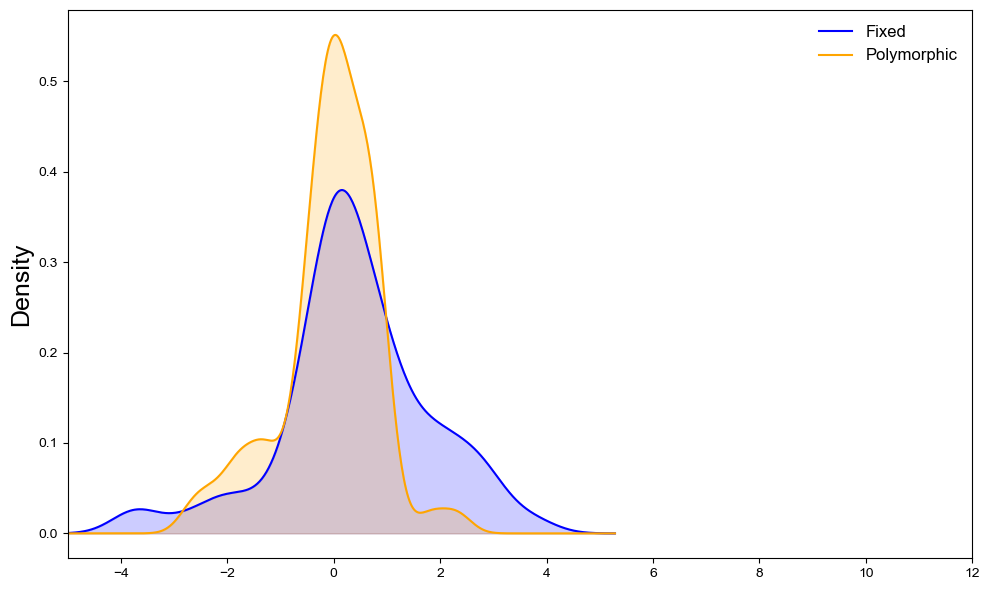

In [103]:


vk = v[v["NearestGene"].isin(["Epcam"])]
vvk = vv[vv["NearestGene"].isin(["Epcam"])]
vvv = prepare_alpha(vk, vvk)
compute_alpha_new(vvv, plot = True)
mwu(vk["PhyloP447"], vvk["PhyloP447"])

In [101]:
metric = "PhyloP447"
c = 0
out = []
v.index = v["NearestGene"]
vv.index = vv["NearestGene"]
vv = vv[(vv["MAFMaxAcrossAncestry"] < 0.75) & (vv["MAFMaxAcrossAncestry"] > 0.25)]
for gene in np.unique(np.intersect1d(v["NearestGene"], vv["NearestGene"])):
    if c%1000 == 0:
        print(c)
    vk = v.loc[gene].copy()
    vvk = vv.loc[gene].copy()
    if len(vk.index) >= 50 and len(vvk.index) >= 25:
        x2 = [np.float64(x) for x in list(vk[metric])]
        yvals2 = [np.float64(j) for j in list(vvk[metric])]
        yvals2.sort()
        vvv = prepare_alpha(vk, vvk, stat = metric)
        for cuttt in [0.5, 0.6, 0.7, 0.8, 0.9]:
            cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
            alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = False, cutoff = cutoff)

            table1 = alpha[2]
            table2 = alpha[3]
            out.append([gene, np.median(x2), len(x2), np.median(yvals2), len(yvals2), (fisher_exact(table1)[1] + fisher_exact(table2)[1])/2, mwu(x2, yvals2)[1], (fisher_exact(table1, alternative = "greater")[1] + fisher_exact(table2, alternative = "greater")[1])/2, mwu(x2, yvals2, alternative = "greater")[1], alpha[0], alpha[1], table1, table2, cuttt])

    c += 1


from statsmodels.stats.multitest import fdrcorrection
df = pd.DataFrame(out)
df = df.sort_values(5)
#df["FDR"] = fdrcorrection(df[5])[1]
df.columns = ["Gene", "Median Fixed PhyloP", "Number Fixed Variants", "Median Polymorphic PhyloP", "Number Polymorphic Variants", "Fisher exact p-value", "MWU p-value", "Fisher exact p-value; alt greater", "MWU p-value; alt greater", "alpha", "Cutoff", "[[dc1, du1], [pc1, pu1]]", "[[dc2, du2], [pc2, pu2]]", "Proportion"]
df.to_csv("Mus_musculus_domesticus_PhyloP447_NonCoding_PerGene_SpecSup75_MAF0.25-0.75.csv", index = False)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


In [102]:
df = df[df["Proportion"] == 0.9].sort_values("Fisher exact p-value; alt greater")
df

,Gene,Median Fixed PhyloP,Number Fixed Variants,Median Polymorphic PhyloP,Number Polymorphic Variants,Fisher exact p-value,MWU p-value,Fisher exact p-value; alt greater,MWU p-value; alt greater,alpha,Cutoff,"[[dc1, du1], [pc1, pu1]]","[[dc2, du2], [pc2, pu2]]",Proportion
35689,Snap91,0.2715,198,0.0990,237,0.000070,0.005978,0.000051,0.002989,0.656011,1.036,"[[48, 150], [23, 214]]","[[48, 150], [24, 213]]",0.9
28474,Pdgfa,-0.0110,122,-0.1255,90,0.000431,0.054606,0.000271,0.027303,0.750753,0.712,"[[36, 86], [8, 82]]","[[36, 86], [9, 81]]",0.9
12519,Epcam,0.2945,70,0.0385,70,0.000631,0.020837,0.000316,0.010418,0.803675,0.798,"[[24, 46], [6, 64]]","[[24, 46], [7, 63]]",0.9
24904,Mrpl1,0.4150,101,0.1510,119,0.001249,0.017791,0.000840,0.008896,0.706739,1.182,"[[27, 74], [11, 108]]","[[27, 74], [12, 107]]",0.9
12974,Eya2,0.1240,297,0.0260,283,0.001921,0.162288,0.000976,0.081144,0.538530,1.473,"[[58, 239], [28, 255]]","[[58, 239], [29, 254]]",0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35899,Sohlh2,0.0650,69,0.3240,34,0.022163,0.044509,1.000000,0.978115,-9.020161,2.430,"[[0, 69], [3, 31]]","[[0, 69], [4, 30]]",0.9
39514,Tpte,0.0360,56,0.1920,65,0.022319,0.487697,1.000000,0.757778,-6.189407,2.956,"[[0, 56], [6, 59]]","[[0, 56], [7, 58]]",0.9
4294,Arl8b,0.0475,54,0.0360,66,0.024007,0.845253,1.000000,0.422627,-5.822404,1.622,"[[0, 54], [6, 60]]","[[0, 54], [7, 59]]",0.9
32379,Rnf17,0.1325,78,0.2410,31,0.013534,0.375280,1.000000,0.814164,-11.501847,2.785,"[[0, 78], [3, 28]]","[[0, 78], [4, 27]]",0.9


In [100]:
df = df[df["Proportion"] == 0.9].sort_values("Fisher exact p-value; alt greater")
df.to_csv("Bleh.csv")

In [91]:
df = pd.DataFrame(out)
df = df.sort_values(5)
#df["FDR"] = fdrcorrection(df[5])[1]
df.columns = ["Gene", "Median Fixed PhyloP", "Number Fixed Variants", "Median Polymorphic PhyloP", "Number Polymorphic Variants", "Fisher exact p-value", "MWU p-value", "Fisher exact p-value; alt greater", "MWU p-value; alt greater", "alpha", "Cutoff", "[[dc1, du1], [pc1, pu1]]", "[[dc2, du2], [pc2, pu2]]", "Proportion"]
df = df.sort_values("Fisher exact p-value; alt greater")
df.head(50)

,Gene,Median Fixed PhyloP,Number Fixed Variants,Median Polymorphic PhyloP,Number Polymorphic Variants,Fisher exact p-value,MWU p-value,Fisher exact p-value; alt greater,MWU p-value; alt greater,alpha,Cutoff,"[[dc1, du1], [pc1, pu1]]","[[dc2, du2], [pc2, pu2]]",Proportion
10365,Gas2,0.0810,327,-0.1790,98,0.000290,0.003939,0.000187,0.001970,0.580611,-0.176,"[[229, 98], [48, 50]]","[[229, 98], [49, 49]]",0.5
19489,Pdgfa,-0.0110,122,-0.1255,90,0.000431,0.054606,0.000271,0.027303,0.750753,0.712,"[[36, 86], [8, 82]]","[[36, 86], [9, 81]]",0.9
20016,Pkp1,0.0855,182,-0.1810,89,0.000950,0.018073,0.000638,0.009036,0.585190,-0.092,"[[112, 70], [35, 54]]","[[112, 70], [36, 53]]",0.6
17029,Mrpl1,0.4150,101,0.1510,119,0.001249,0.017791,0.000840,0.008896,0.706739,1.182,"[[27, 74], [11, 108]]","[[27, 74], [12, 107]]",0.9
8819,Eya2,0.1240,297,0.0260,283,0.001921,0.162288,0.000976,0.081144,0.538530,1.473,"[[58, 239], [28, 255]]","[[58, 239], [29, 254]]",0.9
18023,Nipa2,0.1100,115,-0.0730,67,0.001691,0.130007,0.001094,0.065004,0.671820,0.330,"[[50, 65], [13, 54]]","[[50, 65], [14, 53]]",0.8
17278,Murc,0.2685,276,0.1365,392,0.001991,0.009179,0.001214,0.004590,0.432822,0.847,"[[85, 191], [78, 314]]","[[85, 191], [80, 312]]",0.8
12916,Gtdc1,0.3120,1523,0.1760,540,0.002399,0.037944,0.001265,0.018972,0.267990,0.366,"[[723, 800], [214, 326]]","[[723, 800], [216, 324]]",0.6
14690,Kcnmb4,0.2490,322,0.0300,165,0.002158,0.006762,0.001375,0.003381,0.451883,0.030,"[[208, 114], [82, 83]]","[[208, 114], [83, 82]]",0.5
959,5031425E22Rik,0.2630,285,0.2130,270,0.003027,0.075208,0.001591,0.037604,0.534431,1.272,"[[54, 231], [26, 244]]","[[54, 231], [27, 243]]",0.9


In [78]:
df = pd.DataFrame(out)
df = df.sort_values(5)
#df["FDR"] = fdrcorrection(df[5])[1]
df.columns = ["Gene", "Median Fixed PhyloP", "Number Fixed Variants", "Median Polymorphic PhyloP", "Number Polymorphic Variants", "Fisher exact p-value", "MWU p-value", "Fisher exact p-value; alt greater", "MWU p-value; alt greater", "alpha", "Cutoff", "[[dc1, du1], [pc1, pu1]]", "[[dc2, du2], [pc2, pu2]]", "Proportion"]
df.sort_values("MWU p-value; alt greater").head(50)

,Gene,Median Fixed PhyloP,Number Fixed Variants,Median Polymorphic PhyloP,Number Polymorphic Variants,Fisher exact p-value,MWU p-value,Fisher exact p-value; alt greater,MWU p-value; alt greater,alpha,Cutoff,"[[dc1, du1], [pc1, pu1]]","[[dc2, du2], [pc2, pu2]]",Proportion
361,1810049J17Rik,0.1170,316,0.0110,242,0.078583,0.016521,0.044270,0.008260,0.266003,0.189,"[[150, 166], [96, 146]]","[[150, 166], [97, 145]]",0.6
363,1810049J17Rik,0.1170,316,0.0110,242,0.009630,0.016521,0.005876,0.008260,0.408029,0.772,"[[94, 222], [48, 194]]","[[94, 222], [49, 193]]",0.8
364,1810049J17Rik,0.1170,316,0.0110,242,0.068313,0.016521,0.040619,0.008260,0.386175,1.443,"[[49, 267], [24, 218]]","[[49, 267], [25, 217]]",0.9
362,1810049J17Rik,0.1170,316,0.0110,242,0.065467,0.016521,0.035155,0.008260,0.291891,0.369,"[[119, 197], [72, 170]]","[[119, 197], [73, 169]]",0.7
360,1810049J17Rik,0.1170,316,0.0110,242,0.158459,0.016521,0.084834,0.008260,0.221152,0.013,"[[176, 140], [120, 122]]","[[178, 138], [121, 121]]",0.5
676,4930449E01Rik,0.1525,520,-0.0030,257,0.003286,0.026387,0.001780,0.013193,0.368931,0.133,"[[266, 254], [102, 155]]","[[267, 253], [103, 154]]",0.6
675,4930449E01Rik,0.1525,520,-0.0030,257,0.012510,0.026387,0.006955,0.013193,0.322560,-0.003,"[[310, 210], [128, 129]]","[[310, 210], [129, 128]]",0.5
677,4930449E01Rik,0.1525,520,-0.0030,257,0.008105,0.026387,0.004501,0.013193,0.352351,0.328,"[[208, 312], [77, 180]]","[[208, 312], [78, 179]]",0.7
679,4930449E01Rik,0.1525,520,-0.0030,257,0.667808,0.026387,0.349073,0.013193,0.122548,1.397,"[[58, 462], [25, 232]]","[[58, 462], [26, 231]]",0.9
678,4930449E01Rik,0.1525,520,-0.0030,257,0.116700,0.026387,0.065632,0.013193,0.255805,0.679,"[[131, 389], [51, 206]]","[[131, 389], [52, 205]]",0.8


In [16]:
vv = vv[vv["SpecSup447"] > 75]
v = v[v["SpecSup447"] > 75]
vv = vv[(vv["UnfoldedMAF"] < 0.9) & (vv["UnfoldedMAF"] > 0.1)]
v = v[v["Derived"].isin(["MusDer"])]

In [17]:
toss = []
for i in np.unique(vv["NearestGene"]):
    if "H2-" in i:
        toss.append(i)
        
for i in np.unique(v["NearestGene"]):
    if "H2-" in i:
        toss.append(i)

v = v[~v["NearestGene"].isin(toss)]
vv = vv[~vv["NearestGene"].isin(toss)]

In [20]:
v

,Position,Domesticus,Musculus,Castaneus,Spretus,Caroli,Pahari,Derived,PhyloP447,NearestGene,NearestDist,SpecSup447
54,chr1:3007264,T,T,T,G,G,G,MusDer,0.809,Xkr4,663439,164.0
376,chr1:3047329,T,T,T,C,C,C,MusDer,0.071,Xkr4,623374,299.0
377,chr1:3047444,T,T,T,C,C,C,MusDer,-1.948,Xkr4,623259,313.0
773,chr1:3095359,G,G,G,A,A,A,MusDer,0.392,Xkr4,575344,439.0
774,chr1:3095392,T,T,T,C,C,.,MusDer,0.561,Xkr4,575311,426.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19301938,chrY:2434083,A,A,A,G,G,G,MusDer,0.000,Gm6026,164016,342.0
19301941,chrY:2434362,G,G,G,A,A,A,MusDer,0.455,Gm6026,163737,432.0
19302020,chrY:4381141,T,"T,0.75,12;A,0.25,4",T,G,G,A,MusDer,0.120,Gm8521,520913,365.0
19302033,chrY:6885219,C,C,C,G,G,G,MusDer,2.930,Gm20830,30898,370.0


C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0.08164792241499677,
    AF bin     Alpha  Cutoff               [[dc1, du1], [pc1, pu1]]  \
 0     0.2 -0.244543   2.515  [[138709, 3281363], [54204, 1030380]]   
 1     0.3 -0.153641   2.429   [[149149, 3270923], [38886, 739116]]   
 2     0.4 -0.089997   2.361   [[157517, 3262555], [24427, 464245]]   
 3     0.5 -0.052649   2.318   [[162834, 3257238], [24209, 460080]]   
 4     0.6 -0.019682   2.278   [[167782, 3252290], [17918, 340586]]   
 5     0.7  0.011220   2.242   [[172737, 3247335], [16616, 315967]]   
 6     0.8  0.042592   2.208   [[178143, 3241929], [19917, 378553]]   
 7     0.9  0.064121   2.186   [[182093, 3237979], [19166, 364286]]   
 
                 [[dc2, du2], [pc2, pu2]]  Num Poly in Bin  
 0  [[138822, 3281250], [54254, 1030330]]          1084584  
 1   [[149281, 3270791], [38910, 739092]]           778002  
 2   [[157629, 3262443], [24452, 464220]]           488672  
 3   [[162950, 3257122], [24230, 460059]]           484289  
 4   [[167916, 3252156], [17929,

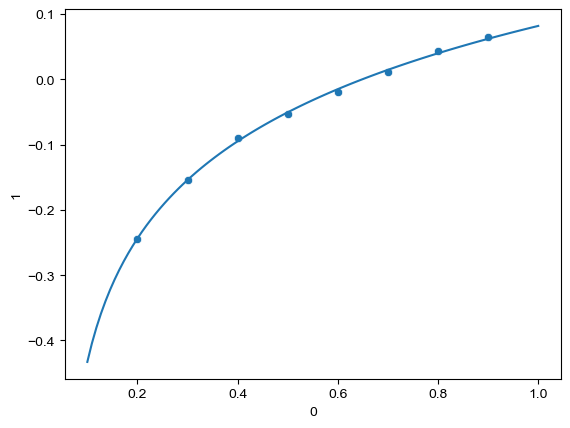

In [24]:
asymptotic_unfold_cutoff(v, vv, start = 0.1, dn_cut = 0.0001, to_plot_curve = True, cuttt = 0.95)

(29874, 12)
(29720, 12)
(29720, 12)
(26661, 12)


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_alt["UnfoldedMAF"] = 1-yvalls_alt["MAFMaxAcrossAncestry"]
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:652: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_ref["UnfoldedMAF"] = yvalls_ref["MAFMaxAcrossAncestry"]


(10748899, 6)
(5642872, 6)
(5642872, 6)


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:559: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_alt["UnfoldedMAF"] = 1-yvalls_alt["MAFMaxAcrossAncestry"]
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:560: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_ref["UnfoldedMAF"] = yvalls_ref["MAFMaxAcrossAncestry"]
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:660: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


(163579, 10)
(162441, 10)
(162441, 10)
(162441, 10)
(120678, 10)


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_alt["UnfoldedMAF"] = 1-yvalls_alt["MAFMaxAcrossAncestry"]
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:755: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_ref["UnfoldedMAF"] = yvalls_ref["MAFMaxAcrossAncestry"]
C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs,

(0.008376130061835244,
    AF bin     Alpha  Cutoff              [[dc1, du1], [pc1, pu1]]  \
 0     0.2 -0.139051   2.164  [[255657, 5534498], [47790, 908157]]   
 1     0.3 -0.105475   2.136  [[262889, 5527266], [27729, 527404]]   
 2     0.4 -0.052615   2.088  [[275540, 5514615], [20131, 382660]]   
 3     0.5 -0.039546   2.075  [[279043, 5511112], [15838, 300934]]   
 4     0.6 -0.024870   2.061  [[282723, 5507432], [12655, 240517]]   
 5     0.7 -0.011830   2.048  [[286239, 5503916], [10715, 203589]]   
 6     0.8 -0.022240   2.059   [[283308, 5506847], [9296, 176755]]   
 7     0.9  0.002639   2.034   [[290079, 5500076], [8958, 170277]]   
 
                [[dc2, du2], [pc2, pu2]]  Num Poly in Bin  
 0  [[255927, 5534228], [47829, 908118]]           955947  
 1  [[263142, 5527013], [27758, 527375]]           555133  
 2  [[275828, 5514327], [20142, 382649]]           402791  
 3  [[279304, 5510851], [15856, 300916]]           316772  
 4  [[283013, 5507142], [12666, 240506]]     

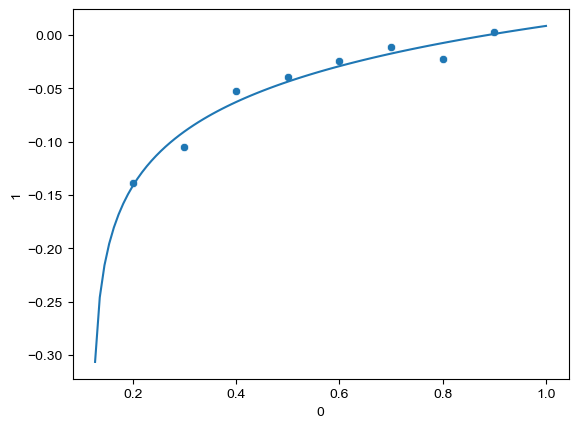

In [12]:
v, yvalls = read_missense(path = "./", maf_cut = 0.1, spec_sup = 250)
yvalls = unfold_missense(yvalls)

v2, yvalls2 = read_noncoding_data_fast(path = "./", maf_cut = 0.1, spec_sup = 250)
yvalls2 = add_unfold(yvalls2)

v3, yvalls3 = read_utr(path = "./", maf_cut = 0.1, spec_sup = 250)
yvalls3 = unfold_utr(yvalls3)

v = pd.concat([v, v2, v3])
yvalls = pd.concat([yvalls, yvalls2, yvalls3])

asymptotic_unfold_cutoff(v, yvalls, start = 0.1, dn_cut = 0.00001, to_plot_curve = True, cuttt = 0.95)

In [2]:
v

NameError: name 'v' is not defined